# LightGlue
In this notebook we match two pairs of images using LightGlue with early stopping and point pruning.

In [11]:
# If we are on colab: this clones the repo and installs the dependencies
from pathlib import Path

from lightglue import LightGlue, SuperPoint, DISK
from lightglue.utils import load_image, rbd
from lightglue import viz2d
import torch

torch.set_grad_enabled(False)
images = Path("assets")

## Load extractor and matcher module
In this example we use SuperPoint features combined with LightGlue.

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 'mps', 'cpu'

extractor = SuperPoint(max_num_keypoints=2048).eval().to(device)  # load the extractor
matcher = LightGlue(features="superpoint").eval().to(device)

## Easy extraction
The top image shows the matches, while the bottom image shows the point pruning across layers. In this case, LightGlue prunes a few points with occlusions, but is able to stop the context aggregation after 4/9 layers.

Inside LightGlue forward method


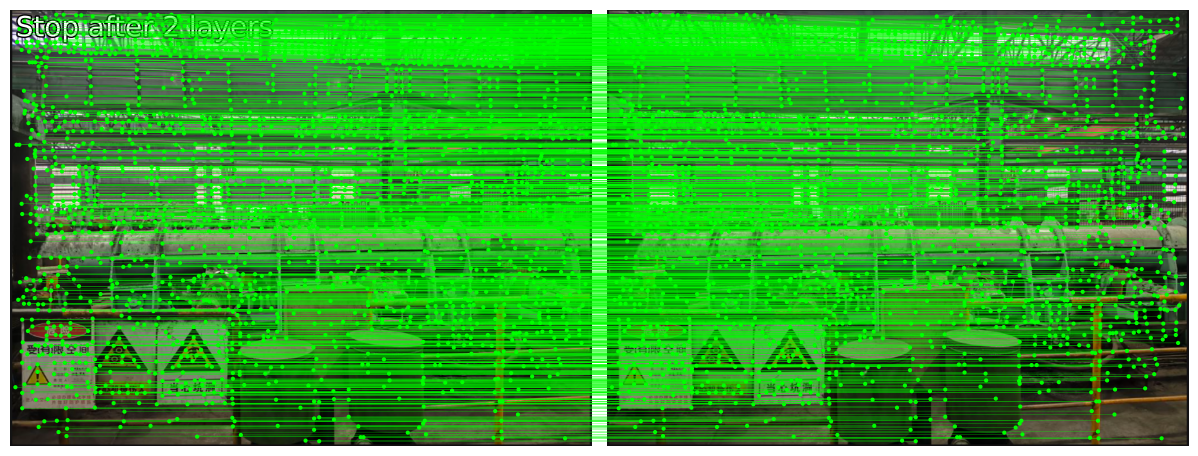

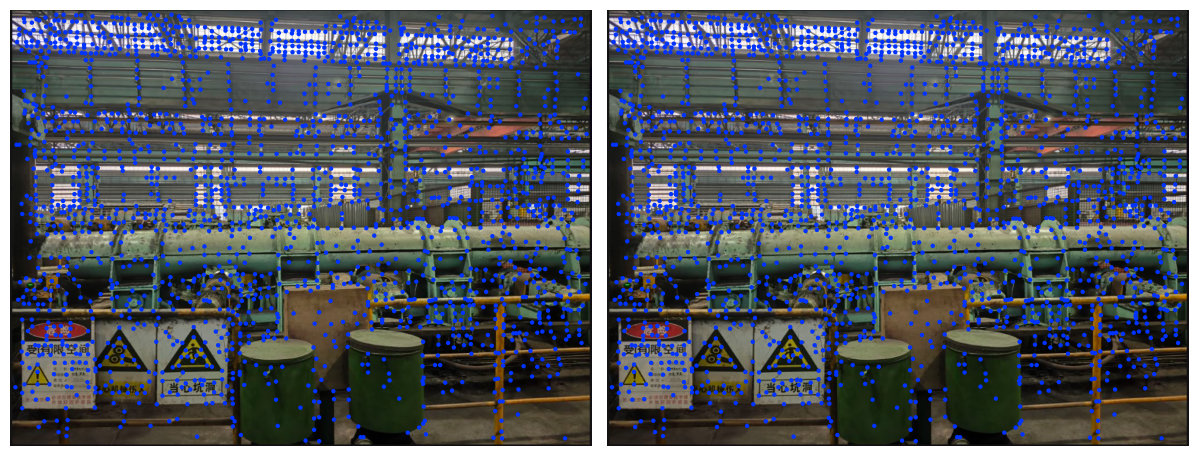

In [13]:
image0 = load_image(images / "image0.PNG")
image1 = load_image(images / "image1.PNG")

feats0 = extractor.extract(image0.to(device))
feats1 = extractor.extract(image1.to(device))
matches01 = matcher({"image0": feats0, "image1": feats1})
feats0, feats1, matches01 = [
    rbd(x) for x in [feats0, feats1, matches01]
]  # remove batch dimension

kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

axes = viz2d.plot_images([image0, image1])
viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)
viz2d.add_text(0, f'Stop after {matches01["stop"]} layers', fs=20)

kpc0, kpc1 = viz2d.cm_prune(matches01["prune0"]), viz2d.cm_prune(matches01["prune1"])
viz2d.plot_images([image0, image1])
viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=10)

## Difficult example
For pairs with significant viewpoint- and illumination changes, LightGlue can exclude a lot of points early in the matching process (red points), which significantly reduces the inference time.

In [ ]:
image0 = load_image(images / "image0.jpg")
image1 = load_image(images / "image1.jpg")

feats0 = extractor.extract(image0.to(device))
feats1 = extractor.extract(image1.to(device))
matches01 = matcher({"image0": feats0, "image1": feats1})
feats0, feats1, matches01 = [
    rbd(x) for x in [feats0, feats1, matches01]
]  # remove batch dimension

kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

axes = viz2d.plot_images([image0, image1])
viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)
viz2d.add_text(0, f'Stop after {matches01["stop"]} layers')

kpc0, kpc1 = viz2d.cm_prune(matches01["prune0"]), viz2d.cm_prune(matches01["prune1"])
viz2d.plot_images([image0, image1])
viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=6)

# Image Registration and fusion
The following figures showcase the original images and the fused image
The implemented code successfully performs image registration and fusion using improved SuperPoint and LightGlue algorithms.

In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import time

def show(name, img):
    cv2.imshow(name, img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

MIN = 10
FLANN_INDEX_KDTREE = 0
starttime = time.time()

img1 = cv2.imread('assets/imahe1.jpeg', 1) # query image
img2 = cv2.imread('assets/image0.jpeg', 1) # train image

imageA = cv2.resize(img1, (0, 0), fx=0.5, fy=0.5)
imageB = cv2.resize(img2, (0, 0), fx=0.5, fy=0.5)

sift = cv2.SIFT_create()
kp1, descrip1 = sift.detectAndCompute(imageA, None)
kp2, descrip2 = sift.detectAndCompute(imageB, None)

indexParams = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
searchParams = dict(checks=50)
flann = cv2.FlannBasedMatcher(indexParams, searchParams)
matches = flann.knnMatch(descrip1, descrip2, k=2)

good = []
for i, (m, n) in enumerate(matches):
    if m.distance < 0.75 * n.distance:
        good.append(m)

if len(good) > MIN:
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    ano_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
    M, mask = cv2.findHomography(src_pts, ano_pts, cv2.RANSAC, 5.0)
    warpImg = cv2.warpPerspective(imageB, np.linalg.inv(M), (imageA.shape[1] + imageB.shape[1], imageB.shape[0]))
    direct = warpImg.copy()

show('res0', warpImg)

rows, cols = imageA.shape[:2]
print(rows)
print(cols)

for col in range(0, cols):
    if imageA[:, col].any() and warpImg[:, col].any():
        left = col
        print('left', left)
        break

for col in range(cols - 1, 0, -1):
    if imageA[:, col].any() and warpImg[:, col].any():
        right = col
        print('right', right)
        break

res = np.zeros([rows, cols, 3], np.uint8)
for row in range(0, rows):
    for col in range(0, cols):
        if not imageA[row, col].any():
            res[row, col] = warpImg[row, col]
        elif not warpImg[row, col].any():
            res[row, col] = imageA[row, col]
        else:
            srcImgLen = float(abs(col - left))
            testImgLen = float(abs(col - right))
            alpha = srcImgLen / (srcImgLen + testImgLen)
            res[row, col] = np.clip(imageA[row, col] * (1 - alpha) + warpImg[row, col] * alpha, 0, 255)

warpImg[0:imageA.shape[0], 0:imageA.shape[1]] = res
line = cv2.line(imageB, (450, 0), (500, 1000), (0, 255, 0), 1)
show('res', warpImg)
#show('line', line)
final = time.time()
print(final - starttime)


Inside LightGlue forward method


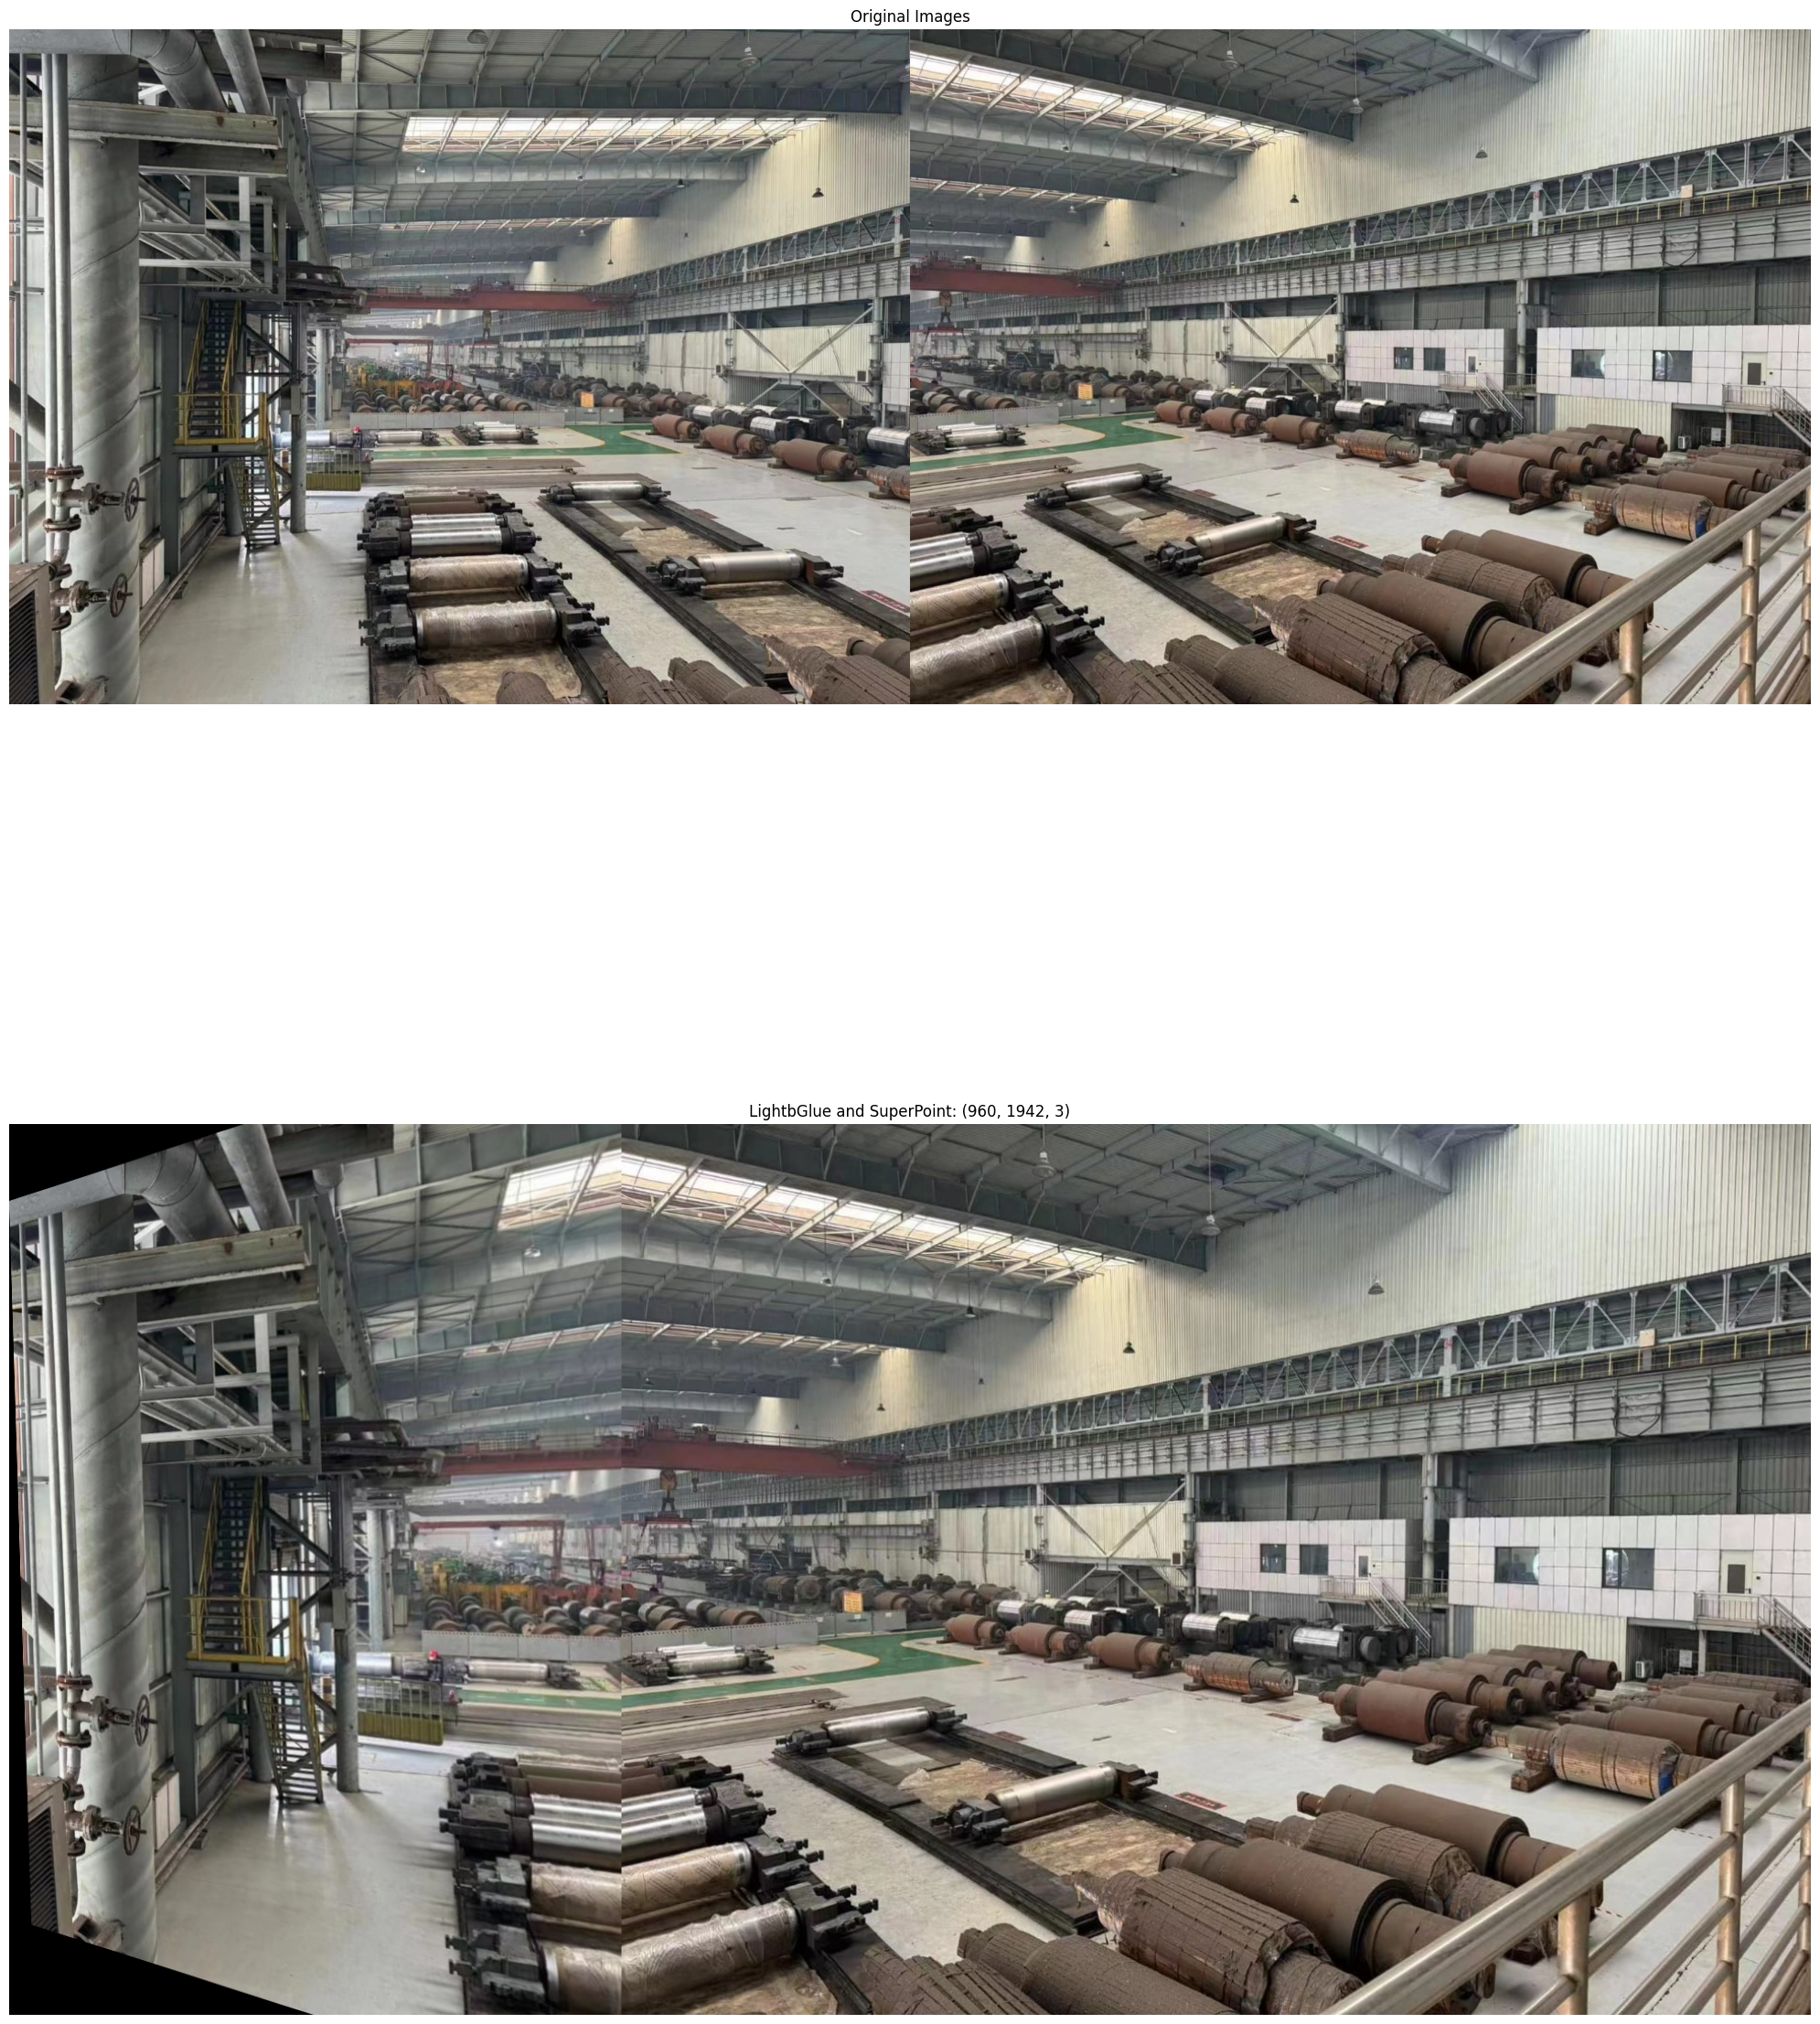

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import torch
from lightglue import LightGlue, SuperPoint
from lightglue.utils import load_image, rbd
from skimage.transform import ProjectiveTransform, warp
from skimage.util import img_as_ubyte

# Initialize
torch.set_grad_enabled(False)
images = Path("assets")

# Load extractor and matcher module
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
extractor = SuperPoint(max_num_keypoints=2048).eval().to(device)
matcher = LightGlue(features="superpoint").eval().to(device)

# Load images
image1_path = images / "image1.jpeg"
image0_path = images / "image0.jpeg"

image1 = load_image(image1_path)
image0 = load_image(image0_path)

def sift_bf(imageA, imageB):
    sift = cv2.SIFT_create()
    kp1, descrip1 = sift.detectAndCompute(imageA, None)
    kp2, descrip2 = sift.detectAndCompute(imageB, None)

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descrip1, descrip2, k=2)
    good = [m for m, n in matches if m.distance < 0.75 * n.distance]

    if len(good) > 10:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        return M
    else:
        return None

# SuperPoint + LightGlue Algorithm
def superpoint_lightglue(image1, image0):
    feats1 = extractor.extract(image1.to(device))
    feats0 = extractor.extract(image0.to(device))
    matches10 = matcher({"image0": feats1, "image1": feats0})
    feats1, feats0, matches10 = [rbd(x) for x in [feats1, feats0, matches10]]

    kpts1, kpts0, matches = feats1["keypoints"], feats0["keypoints"], matches10["matches"]
    m_kpts1, m_kpts0 = kpts1[matches[..., 0]], kpts0[matches[..., 1]]

    src_pts = m_kpts1.cpu().numpy().reshape(-1, 2)
    dst_pts = m_kpts0.cpu().numpy().reshape(-1, 2)

    model = ProjectiveTransform()
    model.estimate(src_pts, dst_pts)
    return model

# Warp and blend images with multi-band blending
def warp_and_blend(image1, image0, model):
    h1, w1 = image1.shape[1], image1.shape[2]
    h0, w0 = image0.shape[1], image0.shape[2]

    corners = np.array([[0, 0], [0, h1], [w1, h1], [w1, 0]])
    warped_corners = model(corners)
    all_corners = np.vstack((warped_corners, corners))
    min_corner = np.min(all_corners, axis=0)
    max_corner = np.max(all_corners, axis=0)
    output_shape = (max_corner - min_corner)[::-1].astype(int)

    translation_matrix = np.array([[1, 0, -min_corner[0]],
                                   [0, 1, -min_corner[1]],
                                   [0, 0, 1]])
    offset_model = ProjectiveTransform(matrix=np.dot(translation_matrix, model.params))

    image1_warped = warp(image1.cpu().numpy().transpose(1, 2, 0), ProjectiveTransform(matrix=translation_matrix).inverse, output_shape=output_shape, cval=-1)
    image0_warped = warp(image0.cpu().numpy().transpose(1, 2, 0), offset_model.inverse, output_shape=output_shape, cval=-1)

    # Blend images using multi-band blending
    mask1 = (image1_warped == -1)
    mask0 = (image0_warped == -1)
    image1_warped[mask1] = 0
    image0_warped[mask0] = 0

    blended_image = np.where(mask1, image0_warped, image1_warped)
    blended_image = np.where(mask0, image1_warped, blended_image)

    return img_as_ubyte(blended_image)

imageA = cv2.imread(str(image1_path))
imageB = cv2.imread(str(image0_path))

# Resize images for SIFT+BF to match dimensions
imageA_resized = cv2.resize(imageA, (image0.shape[2], image0.shape[1]))
imageB_resized = cv2.resize(imageB, (image0.shape[2], image0.shape[1]))

# SIFT+BF Matching and Warping
M_sift = sift_bf(imageA_resized, imageB_resized)
if M_sift is not None:
    # Define the rotation angle in degrees
    angle = -1
    # Compute the rotation matrix
    center = (imageA_resized.shape[1] / 2, imageA_resized.shape[0] / 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1)
    
    # Convert the rotation matrix to 3x3
    rotation_matrix_3x3 = np.vstack([rotation_matrix, [0, 0, 1]])
    
    # Apply translation and rotation to the homography matrix
    translation_up = np.array([[1, 0, 0],
                               [0, 1, +30], 
                               [0, 0, 1]])
    M_sift = np.dot(translation_up, M_sift)
    M_sift = np.dot(rotation_matrix_3x3, M_sift)
    
    # Create an empty canvas large enough to hold both images side by side
    stitched_image_sift = np.zeros((imageA_resized.shape[0], imageA_resized.shape[1] + imageB_resized.shape[1], 3), dtype=np.uint8)
    
    # Warp imageA_resized to align with imageB_resized
    warped_imageA = cv2.warpPerspective(imageA_resized, np.linalg.inv(M_sift), (stitched_image_sift.shape[1], stitched_image_sift.shape[0]))
    
    # Place imageB_resized on the right side of the canvas
    stitched_image_sift[:, -imageB_resized.shape[1]:] = imageB_resized
    
    # Blend the warped imageA on the left side of the canvas
    stitched_image_sift[:, :imageA_resized.shape[1]] = warped_imageA[:, :imageA_resized.shape[1]]

# SuperPoint+LightGlue Matching and Warping
model_lightglue = superpoint_lightglue(image1, image0)
warpImg_lightglue = warp_and_blend(image1, image0, model_lightglue)

# Ensure the LightGlue stitched image has the same dimensions as the input images
warpImg_lightglue_resized = cv2.resize((warpImg_lightglue * 255).astype(np.uint8), (image0.shape[2], image0.shape[1]))

# Multi-band blending function
def multiband_blending(img1, img2, levels=4):
    if len(img1.shape) == 2:
        img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    if len(img2.shape) == 2:
        img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)

    # Ensure the images are the same size
    img1 = cv2.resize(img1, (img2.shape[1], img2.shape[0]))

    gpA = [img1]
    gpB = [img2]

    for i in range(levels):
        img1 = cv2.pyrDown(img1)
        img2 = cv2.pyrDown(img2)
        gpA.append(np.float32(img1))
        gpB.append(np.float32(img2))

    lpA = [gpA[levels-1]]
    lpB = [gpB[levels-1]]
    for i in range(levels-1, 0, -1):
        GE_A = cv2.pyrUp(gpA[i])
        GE_B = cv2.pyrUp(gpB[i])
        L_A = np.subtract(gpA[i-1], GE_A[:gpA[i-1].shape[0], :gpA[i-1].shape[1]])
        L_B = np.subtract(gpB[i-1], GE_B[:gpB[i-1].shape[0], :gpB[i-1].shape[1]])
        lpA.append(L_A)
        lpB.append(L_B)

    LS = []
    for la, lb in zip(lpA, lpB):
        rows, cols, dpt = la.shape
        ls = np.hstack((la[:, 0:int(cols/2)], lb[:, int(cols/2):]))
        LS.append(ls)

    ls_ = LS[0]
    for i in range(1, levels):
        ls_ = cv2.pyrUp(ls_)
        # Ensure the sizes match before adding
        min_shape = (min(ls_.shape[0], LS[i].shape[0]), min(ls_.shape[1], LS[i].shape[1]))
        ls_ = ls_[:min_shape[0], :min_shape[1]]
        LS[i] = LS[i][:min_shape[0], :min_shape[1]]
        ls_ = cv2.add(ls_, LS[i])

    return ls_


# Blend SIFT+BF stitched image
sift_blended = multiband_blending(stitched_image_sift[:, :imageA_resized.shape[1]], stitched_image_sift[:, -imageB_resized.shape[1]:])

# Display results
fig, axs = plt.subplots(2, 1, figsize=(20, 30))

# Step 1: Display original images side by side
axs[0].imshow(np.hstack((image1.cpu().numpy().transpose(1, 2, 0), image0.cpu().numpy().transpose(1, 2, 0))))
axs[0].set_title('Original Images')
axs[0].axis('off')

# Step 2: Display SIFT+BF results with improved boundary handling on imageA
if M_sift is not None:
    # Crop the stitched image to remove excess space on the left
    x_start = np.min(np.where(np.any(stitched_image_sift > 0, axis=(0, 2))))
    cropped_stitched_image_sift = stitched_image_sift[:, x_start:]
    
    axs[1].imshow(cv2.cvtColor(cropped_stitched_image_sift, cv2.COLOR_BGR2RGB))
    axs[1].set_title(f'LightbGlue and SuperPoint: {cropped_stitched_image_sift.shape}')
    axs[1].axis('off')

# # Step 3: Display Multi-band Blended Image
# axs[2].imshow(cv2.cvtColor(sift_blended.astype(np.uint8), cv2.COLOR_BGR2RGB))
# axs[2].set_title('Multi-band Blended Image')
# axs[2].axis('off')

plt.tight_layout()
plt.show()
